# Conditional variational autoencoder
Variational autoencoder for tabular data, oriented upon: https://lschmiddey.github.io/fastpages_/2021/03/14/tabular-data-variational-autoencoder.html 

Adopted with one hot encoding for tabular data
## Load Json Database of recipes

In [1]:
import json
import sys
sys.path.append('../..')

from utils import validateJson

jsonData = json.load(open('recipes_valid.json'))
#validateJson.validateRecimeJson(jsonData)

print(jsonData.keys())

dict_keys(['title', 'ingredients', 'instructions'])


In [1]:
import pickle
import pandas as pd

with open('recipes_valid.pkl', 'rb') as f:
    pklData = pd.DataFrame(pickle.load(f))

print(pklData.keys())

Index(['title', 'ingredients', 'instructions'], dtype='object')


## Convert list of ingredients to pandas dataframe and one hot encode the dataframe.

In [2]:
data = []

for recipeIndex, item in enumerate(pklData.iterrows()):
    rowData = {}
    for index, ingredient in item[1]['ingredients'].iterrows():
        for key in ingredient.keys():
            rowData[key+str(index)] = ingredient[key]
    data.append(rowData)
    if recipeIndex == 10000:
        break

del pklData
frame = pd.DataFrame(data)
del data


In [4]:
from sklearn.preprocessing import OneHotEncoder


dropColumns = []
for column in frame.columns:
    if 'amount' in column:
        dropColumns.append(column)
frameStripped = frame.drop(columns=dropColumns)

enc = OneHotEncoder()
enc.fit(frameStripped)
frameStrippedEncodedSki = pd.DataFrame(data=enc.transform(frameStripped).toarray(), columns=enc.get_feature_names(frameStripped.columns))

frameEncodedSki = pd.concat([frame[dropColumns], frameStrippedEncodedSki], axis=1)
del frame

## VAE
### Setup

In [6]:
# Import pytorch dependencies
import torch
from torch import optim
from torch.utils.data import DataLoader

# Import additional libraries
import pandas as pd
import numpy as np

# Import custom autoencoder
from cvae import VariationalAutoEncoder

# Import custom helper functions
from networkUtils import DataBuilder, CustomLoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Setup Datasets + Hyperparameters

In [7]:
batch_size = 1024
# Train/Testdataset split is defined in the DataBuilder
traindata_set=DataBuilder(frameEncodedSki, train=True)
testdata_set=DataBuilder(frameEncodedSki, train=False)
# Definition of batches
trainloader=DataLoader(dataset=traindata_set,batch_size=batch_size)
testloader=DataLoader(dataset=testdata_set,batch_size=batch_size)

In [8]:
D_in = testdata_set.x.shape[1]
H = 1024
H2 = 128
latent_dim = 32
model = VariationalAutoEncoder(D_in, H, H2, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = CustomLoss()

### Train Model

In [9]:
epochs = 50
log_interval = 5
val_losses = []
train_losses = []
test_losses = []

In [10]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [11]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_mse(recon_batch, data, mu, logvar)
            test_loss += loss.item()
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average test loss: {:.4f}'.format(
                epoch, test_loss / len(testloader.dataset)))
        test_losses.append(test_loss / len(testloader.dataset))

In [12]:
for epoch in range(1,epochs+1):
    train(epoch)
    test(epoch)

====> Epoch: 5 Average training loss: 37276.9583
====> Epoch: 5 Average test loss: 10772.3512
====> Epoch: 5 Average test loss: 30791.0317
====> Epoch: 5 Average test loss: 40755.0397
====> Epoch: 10 Average training loss: 34841.3426
====> Epoch: 10 Average test loss: 10241.4735
====> Epoch: 10 Average test loss: 29755.2809
====> Epoch: 10 Average test loss: 39232.3699
====> Epoch: 15 Average training loss: 32663.8803
====> Epoch: 15 Average test loss: 9783.5568
====> Epoch: 15 Average test loss: 28854.7424
====> Epoch: 15 Average test loss: 37906.1546
====> Epoch: 20 Average training loss: 30308.6494
====> Epoch: 20 Average test loss: 9362.5212
====> Epoch: 20 Average test loss: 28024.1006
====> Epoch: 20 Average test loss: 36689.6688
====> Epoch: 25 Average training loss: 28370.7311
====> Epoch: 25 Average test loss: 8986.8690
====> Epoch: 25 Average test loss: 27307.7061
====> Epoch: 25 Average test loss: 35619.9953
====> Epoch: 30 Average training loss: 26346.4409
====> Epoch: 30 A

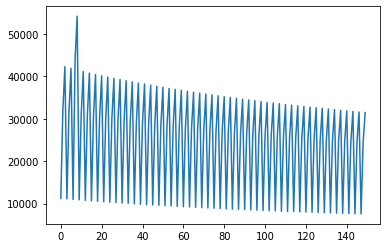

In [21]:
import matplotlib.pyplot as plt

plt.plot(test_losses)

In [13]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

In [14]:
scaler = trainloader.dataset.standardizer
recon_row = scaler.inverse_transform(recon_batch[0].cpu().numpy())
real_row = scaler.inverse_transform(testloader.dataset.x[0].cpu().numpy())

In [15]:
cols = frameEncodedSki.columns
df = pd.DataFrame(np.stack((recon_row, real_row)), columns = cols)
df

,amount0,amount1,amount2,amount3,amount4,amount5,amount6,amount7,amount8,amount9,...,ingredient19_red cabbage,ingredient19_salt,ingredient19_salt & freshly ground black pepper,ingredient19_semi - sweet chocolate baking squares,ingredient19_sour cream,ingredient19_sugar,ingredient19_vanilla extract,ingredient19_vegetable oil,ingredient19_watercress,ingredient19_nan
0,7.113168,11.29177,-0.967218,-22.85685,-37.11483,-52.376343,-79.513397,-87.212692,-99.127586,-103.504112,...,1.779187e-04,-0.132584,5.887541e-04,2.944219e-04,5.214479e-04,2.058723e-03,-0.338214,2.458877e-04,1.195001e-03,0.997262
1,1.000000,12.00000,1.000000,4.00000,1.00000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,...,1.530030e-12,0.000000,1.530030e-12,1.530030e-12,1.530030e-12,1.530030e-12,0.000000,1.530030e-12,1.530030e-12,1.000000


### Draw random samples form latent space and generate new data

In [16]:
sigma = torch.exp(logvar/2)
# sample z from q
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

In [17]:
with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

fake_data = scaler.inverse_transform(pred)
df_fake = pd.DataFrame(fake_data, columns = cols)
df_fake.head(10)

,amount0,amount1,amount2,amount3,amount4,amount5,amount6,amount7,amount8,amount9,...,ingredient19_red cabbage,ingredient19_salt,ingredient19_salt & freshly ground black pepper,ingredient19_semi - sweet chocolate baking squares,ingredient19_sour cream,ingredient19_sugar,ingredient19_vanilla extract,ingredient19_vegetable oil,ingredient19_watercress,ingredient19_nan
0,-54.643333,8.464703,-23.849037,-46.762249,-11.704367,-50.763882,9.655569,-4.890543,-35.984108,-32.917542,...,-0.003542,-0.171036,0.008243,0.008889,-0.001633,0.005587,1.066403,0.005762,0.009297,0.933798
1,-8.198895,48.843628,12.564846,28.113548,38.520695,8.296011,-69.230057,-108.528748,-104.480423,-103.974541,...,0.001594,0.024268,0.008281,-0.012344,0.009256,0.015636,-0.111335,-0.008282,0.003858,0.961602
2,-53.268463,-6.611197,6.581358,-10.991823,6.314904,-13.469001,23.389643,27.542671,16.420851,9.416067,...,-0.001536,0.730762,-0.006190,0.003020,0.002262,0.003317,0.918662,0.001120,-0.001558,0.979414
3,31.935699,-5.205367,-63.531578,9.469636,-47.642174,-51.544903,-32.187901,-36.742691,-2.828315,-1.414477,...,-0.000743,-0.540841,0.001544,0.007428,0.015302,0.007410,0.406386,0.007119,0.026980,0.901791
4,-29.415302,-15.958298,9.655302,31.085976,-9.852930,6.294065,-54.660088,-52.013031,-5.383628,-40.072418,...,-0.010421,-0.165793,0.004188,0.000765,-0.006691,0.010749,0.024642,0.020205,-0.002044,1.005334
5,48.116322,4.613948,15.040253,23.093060,-3.084524,-27.111021,-31.417355,-28.262009,-73.445892,-105.938843,...,0.002200,0.795894,-0.002391,0.002454,0.007808,-0.003090,-0.559171,-0.003150,0.006618,1.034229
6,18.968622,48.066986,24.173140,3.863648,-55.041466,-33.135906,-99.640480,-98.486153,-91.083275,-112.023621,...,-0.021983,1.571026,-0.001794,0.002571,-0.009183,-0.015541,-0.407195,0.006882,-0.008791,1.034692
7,60.263493,25.301115,23.273291,-1.381223,14.361619,2.059654,-11.469217,-57.428047,-65.481354,-85.523872,...,0.011578,0.408448,0.001873,-0.012749,-0.001648,-0.008059,0.306224,-0.002577,0.004572,1.006461
8,13.697342,19.197203,0.730694,-47.672649,-73.586937,-112.118561,-139.106705,-145.502808,-151.662811,-143.193954,...,0.007042,-0.505781,0.018766,-0.000682,0.002647,-0.004375,-0.838152,0.000154,0.010873,0.946724
9,2.636804,3.255673,13.517341,20.819647,2.583613,17.659641,7.953196,-9.724266,-56.210335,-79.561081,...,-0.008233,-0.830796,0.012370,-0.015759,-0.000293,0.003021,-0.470671,0.021518,-0.011705,1.012265


In [18]:
df_fake_stripped = df_fake.drop(columns=dropColumns)
df_fake_stripped_decoded = pd.DataFrame(data=enc.inverse_transform(df_fake_stripped), columns=frameStripped.columns)
df_fake_decoded = pd.concat([df_fake[dropColumns], df_fake_stripped_decoded], axis=1)
df_fake_decoded

,amount0,amount1,amount2,amount3,amount4,amount5,amount6,amount7,amount8,amount9,...,unit15,ingredient15,unit16,ingredient16,unit17,ingredient17,unit18,ingredient18,unit19,ingredient19
0,-54.643333,8.464703,-23.849037,-46.762249,-11.704367,-50.763882,9.655569,-4.890543,-35.984108,-32.917542,...,NaN,saffron,NaN,cheese ravioli,cubic centimetre,rice,NaN,NaN,NaN,black pepper
1,-8.198895,48.843628,12.564846,28.113548,38.520695,8.296011,-69.230057,-108.528748,-104.480423,-103.974541,...,NaN,miso,NaN,sweet chili sauce,drop,whole wheat flour,NaN,cilantro,NaN,NaN
2,-53.268463,-6.611197,6.581358,-10.991823,6.314904,-13.469001,23.389643,27.542671,16.420851,9.416067,...,NaN,fillets,NaN,crabmeat,cubic centimetre,cider vinegar,NaN,vegetable oil,NaN,NaN
3,31.935699,-5.205367,-63.531578,9.469636,-47.642174,-51.544903,-32.187901,-36.742691,-2.828315,-1.414477,...,NaN,saffron threads,NaN,toasted sesame oil,fluid ounce,red food coloring,NaN,corn tortillas,NaN,fresh dill sprigs
4,-29.415302,-15.958298,9.655302,31.085976,-9.852930,6.294065,-54.660088,-52.013031,-5.383628,-40.072418,...,NaN,hoisin sauce,NaN,black beans,ounce,powdered ginger,NaN,cilantro,NaN,Worcestershire sauce
5,48.116322,4.613948,15.040253,23.093060,-3.084524,-27.111021,-31.417355,-28.262009,-73.445892,-105.938843,...,NaN,radish sprouts,NaN,garlic and red chile paste,ounce,lemon slices,NaN,NaN,NaN,NaN
6,18.968622,48.066986,24.173140,3.863648,-55.041466,-33.135906,-99.640480,-98.486153,-91.083275,-112.023621,...,NaN,mild chile,NaN,light cream cheese,NaN,bittersweet chocolate,NaN,parsnips,NaN,salt
7,60.263493,25.301115,23.273291,-1.381223,14.361619,2.059654,-11.469217,-57.428047,-65.481354,-85.523872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,13.697342,19.197203,0.730694,-47.672649,-73.586937,-112.118561,-139.106705,-145.502808,-151.662811,-143.193954,...,NaN,chicken breasts,NaN,baguette,NaN,croutons,NaN,sugar cubes,NaN,nutmeg
9,2.636804,3.255673,13.517341,20.819647,2.583613,17.659641,7.953196,-9.724266,-56.210335,-79.561081,...,NaN,semisweet chocolate,NaN,graham crackers,inch,cold water,NaN,parmesan cheese,NaN,NaN


In [19]:
class Ingredient:
    def __init__(self, amount, unit, ingredient) -> None:
        self.amount = amount
        self.unit = unit
        self.ingredient = ingredient

    def __repr__(self) -> str:
        return "\nAmount: " + str(self.amount) + "\n Unit: " + str(self.unit) + "\n Ingredient: " + str(self.ingredient)

recipes = []
lenIngredients = int(len(df_fake_decoded.columns)/3)
for value in df_fake_decoded.values:
    ingredients = []
    for index in range(0,lenIngredients):
        frame = []
        frame.append(value[index])
        frame.append(value[index+lenIngredients])
        frame.append(value[index+2*lenIngredients])
        ingredients.append(frame)
    recipes.append(ingredients)

pd.DataFrame(recipes)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"[-54.643333435058594, , nan]","[8.464702606201172, bite size shredded whole w...","[-23.849037170410156, , kilogram]","[-46.76224899291992, flax seeds, fast rise yeast]","[-11.704366683959961, , nan]","[-50.76388168334961, dried ancho chile powder,...","[9.655569076538086, kilogram, nan]","[-4.890542984008789, quick oats, cabbage]","[-35.984107971191406, , nan]","[-32.91754150390625, jam, dried cranberries]","[-51.73106002807617, cup, nan]","[-24.222578048706055, sweetened coconut, saffron]","[-34.85557556152344, cup, nan]","[-63.04339599609375, marmalade, cheese ravioli]","[-99.91354370117188, , cubic centimetre]","[-73.80564880371094, low - sodium tamari, rice]","[-86.25032806396484, nan, nan]","[-90.1850814819336, gem lettuce, nan]","[-90.87747192382812, nan, nan]","[-89.80912017822266, tomato ketchup, black pep..."
1,"[-8.198894500732422, , nan]","[48.8436279296875, guajillo chilies, hard - co...","[12.56484603881836, , nan]","[28.113548278808594, halloumi cheese, chili - ...","[38.520694732666016, , nan]","[8.296010971069336, hot Italian sausage, dried...","[-69.23005676269531, , nan]","[-108.52874755859375, Certo, Frangelico]","[-104.48042297363281, gallon, nan]","[-103.97454071044922, green tomatoes, cider]","[-101.42188262939453, , nan]","[-124.24237060546875, heirloom tomatoes, miso]","[-134.9367218017578, nan, nan]","[-141.28367614746094, salted macadamia nuts, s...","[-134.8311767578125, nan, drop]","[-115.46652221679688, fresh garlic clove, whol...","[-108.69148254394531, nan, nan]","[-92.87630462646484, ground beef, cilantro]","[-94.02088928222656, nan, nan]","[-95.7415542602539, green peas, nan]"
2,"[-53.268463134765625, , ]","[-6.611197471618652, onion powder, raspberries]","[6.581357955932617, , cup]","[-10.991823196411133, bay scallop, cooked chic...","[6.31490421295166, , inch]","[-13.469000816345215, coriander leaves, chilies]","[23.3896427154541, tonne, fluid ounce]","[27.54267120361328, pasta, fajita seasoning mix]","[16.42085075378418, , nan]","[9.416067123413086, jalapeno juice, lime]","[-25.178525924682617, teaspoon, nan]","[-4.365599632263184, tomatoes and green chilie...","[-27.34524917602539, , nan]","[-32.298152923583984, Spanish onion, crabmeat]","[-63.1605110168457, cup, cubic centimetre]","[-65.14175415039062, soymilk, cider vinegar]","[-90.35520935058594, cup, nan]","[-106.2296142578125, turbinado sugar, vegetabl...","[-109.8724594116211, , nan]","[-100.19818115234375, cooking sherry, nan]"
3,"[31.935699462890625, , teaspoon]","[-5.205367088317871, Velveeta reduced fat chee...","[-63.531578063964844, cup, kilogram]","[9.469635963439941, saffron, fresh sage leaves]","[-47.642173767089844, , inch]","[-51.54490280151367, key lime, vegetable stock]","[-32.18790054321289, kilogram, ]","[-36.74269104003906, white bread, unsweetened ...","[-2.8283145427703857, , quart]","[-1.414476752281189, green chili, pimientos]","[18.591814041137695, tablespoon, nan]","[-3.3636081218719482, great northern beans, sa...","[-27.71971893310547, cup, nan]","[-34.898216247558594, lasagna noodles, toasted...","[-26.422012329101562, cup, fluid ounce]","[-31.265464782714844, strawberry pie filling, ...","[-48.193084716796875, teaspoon, nan]","[-72.3926773071289, lemon juice concentrate, c...","[-85.70503234863281, , nan]","[-87.65703582763672, Boar's Head Chipotle Chic..."
4,"[-29.415302276611328, , drop]","[-15.958297729492188, flour tortilla, ginger -...","[9.655302047729492, , nan]","[31.085975646972656, mint jelly, English cucum...","[-9.852930068969727, tablespoon, nan]","[6.294065475463867, Hershey's syrup, yoghurt]","[-54.66008758544922, , nan]","[-52.013031005859375, peaches, cranberries]","[-5.383627891540527, cup, nan]","[-40.072418212890625, papayas, sea salt]","[-30.18531608581543, , nan]","[-49.47676467895508, hot Italian sausage links...","[-62.24425506591797, , nan]","[-88.82472229003906, baby carrots, black beans]","[-65.5212631225586, , ounce]","[-86.148